In [1]:
# Load Datasets
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append("../classifier/")
from model.data import CGDataset, VectorCGDataset, NeighbourCGDataset
from model.model import DiffCG, MinCutCG, DMoNCG, DeepCG
from run.train import training
from run.test import test


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cpu") #("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

dataset_dict = {c.__name__: c for c in {CGDataset, VectorCGDataset, NeighbourCGDataset}}

if vectorize:
    dataset_v = "VectorCGDataset"
elif k > 0:
    dataset_v = "NeighbourCGDataset"
else:
    dataset_v = "CGDataset"

#Training Set
training_dir = "../data/train_set"
rmsd_list = "../data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = dataset_dict[dataset_v](training_dir, rmsd_list, k=k)# T.NormalizeScale()) #, transform=transform_fn

#Validation Set
val_dir = "../data/val_set"
val_rmsd = "../data/val_rmsd_list.txt"
val_dataset = dataset_dict[dataset_v](val_dir, val_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Test Data
test_dir = "../data/test_set"
test_rmsd = "../data/test_rmsd_list.txt"
test_dataset = dataset_dict[dataset_v](test_dir, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "../data/old_training_set"
st_test_rmsd = "../data/old_train_rmsd_list.txt"
st_test_dataset = dataset_dict[dataset_v](st_test_dir, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

#Rotated Test Sets
test_dir_rot = "../data/test_set_rot"
test_rmsd = "../data/test_rmsd_list.txt"
rot_test_dataset = dataset_dict[dataset_v](test_dir_rot, test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

fst_test_rot = "../data/5st_test_rot"
fst_rot_dataset = dataset_dict[dataset_v](fst_test_rot, st_test_rmsd, k=k)#, transform=T.NormalizeScale()) #, transform=transform_fn

Pytorch Version 1.11.0
Cuda is available: True
Using device: cpu


TODO:
*  Should Vector and Neighbour datasets inherit from CGDataset, to avoid code duplication?
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture?
    * use the module `JumpingKnowledge` in PyG

Normalization:
*  BatchNorm: no improvement seen, maybe with larger datasets?
*  PairNorm: Training took longer, results were nonsense
*  DiffGroupNorm: figure out how to configure it (in channels not the same as for the layers)
*  GraphNorm: Strange results, try again. (maybe with GINConv layers, as is shown in the paper?), doesnt seem to work in this case (at least with normal data)
*  LayerNorm: Training took longer, results were worse than without norm
*  InstanceNorm: doesnt work for 3D input? --> try pytorch instancenorm1(?)d instead of pygs

--> try data normalization/standardization (beforehand)

In [2]:
#model = MinCutCG(training_dataset.num_node_features)
model = DeepCG(training_dataset.num_node_features, [11, 11, 22, 8])

In [3]:
#Training
parent_dir = "../run_data/"

#with th.autograd.detect_anomaly():
training(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=100,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    #num_workers=0,
    #resume="../run_data/2022-07-04_10-2_MinCutCG/model_data/epoch_1999.pth",
    burn_in=50)

11.07.2022 16:12:24 Creating Training Directory at ../run_data/2022-07-11_16-12_DeepCG/
11.07.2022 16:12:24 Loading Datasets
11.07.2022 16:12:24 Start Training


RuntimeError: index 66 is out of bounds for dimension 0 with size 64

In [3]:
#get training run data

run_dir = "../run_data/2022-07-11_11-15_DeepCG"#"/scr/risa/mgeyer/GCN/run_data/2022-07-08_12-48_MinCutCG"#
burn_in = 0

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss 0.9236 in epoch 89
Minimum Validation Loss (after 0 epochs) 15.4294 in epoch 99
Minimum MAE (after 0 epochs) 15.9191 in epoch 99


Validation Loss at 89 is 16.3448
5 before select
16.2738, 15.9380, 16.1381, 16.0200, 16.4577
5 after select
16.2760, 15.9779, 16.1477, 16.0740, 15.6474
MAE at 89 is 16.8344


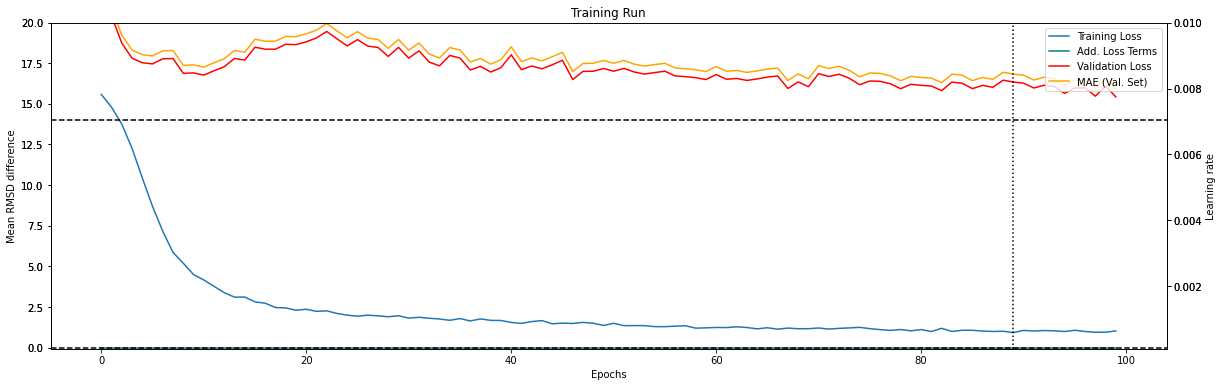

In [5]:
#plot the training run
select = 89

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(figsize=(20, 6))#layout="constrained", 
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ylim([(min(epoch_losses)-1), 20]) #max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0.0, c = "black", ls = "--")
ax1.axhline(y=14, c = "black", ls = "--")

ax2.set_ylim([(min(learning_rates)*0.1), max(learning_rates)*10])

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 89
Test Set
Minimum Loss: Label = 22.3040, Prediction = 22.3496, Loss = 0.0010
Maximum Loss: Label = 0.0000, Prediction = 59.8461, Loss = 59.3461
Mean Test loss: 	 17.0259
Std. Dev. of Test loss:  14.5299
Min loss: 		 0.0010
First Quantile: 	 6.5590
Median: 		 12.6818
Third Quantile: 	 22.1150
Max Loss: 		 59.3461
LinregressResult(slope=-0.5139708071358191, intercept=30.372959640435646, rvalue=-0.46870497916776194, pvalue=1.558637987558289e-16, stderr=0.0584127556510085, intercept_stderr=1.6808391849370492)


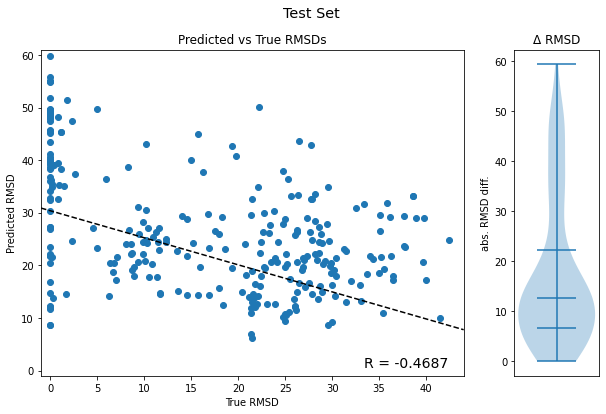

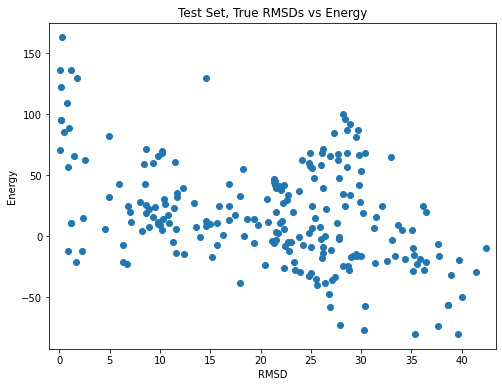

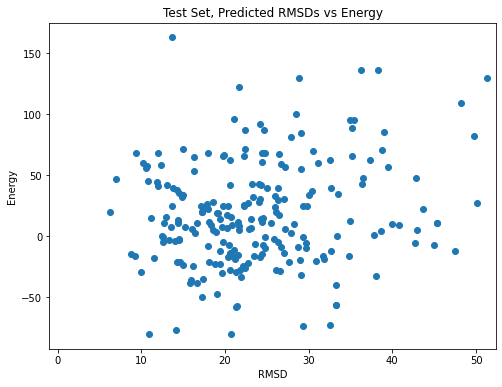

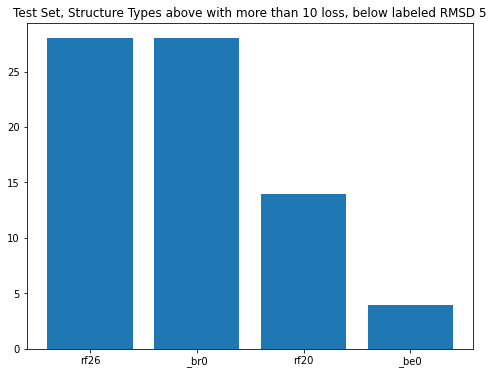

Prediction below 0: Label 0.0000, Pred -0.1788
Prediction below 0: Label 0.2310, Pred -0.3708
Prediction below 0: Label 0.1340, Pred -0.3194
Prediction below 0: Label 0.1390, Pred -0.5116
Prediction below 0: Label 0.0000, Pred -0.1610
Prediction below 0: Label 0.0920, Pred -0.3592
Prediction below 0: Label 0.0000, Pred -0.1857
Prediction below 0: Label 0.3800, Pred -0.4769
Prediction below 0: Label 0.3260, Pred -0.3662
Prediction below 0: Label 0.1490, Pred -0.2861
Prediction below 0: Label 0.0000, Pred -0.0073
5S and tRNA Test Set
Minimum Loss: Label = 0.0000, Prediction = -0.0073, Loss = 0.0000
Maximum Loss: Label = 1.1670, Prediction = 33.7569, Loss = 32.0899
Mean Test loss: 	 4.7385
Std. Dev. of Test loss:  5.1349
Min loss: 		 0.0000
First Quantile: 	 1.0966
Median: 		 3.2725
Third Quantile: 	 6.2883
Max Loss: 		 32.0899
LinregressResult(slope=0.7313366829949287, intercept=2.479254382335382, rvalue=0.679783482367813, pvalue=9.859138406828241e-148, stderr=0.02399840737891581, interc

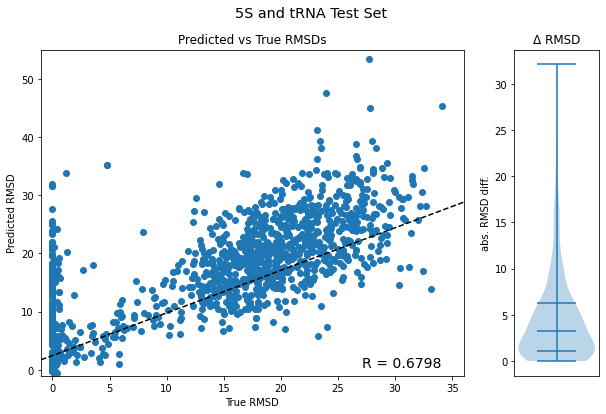

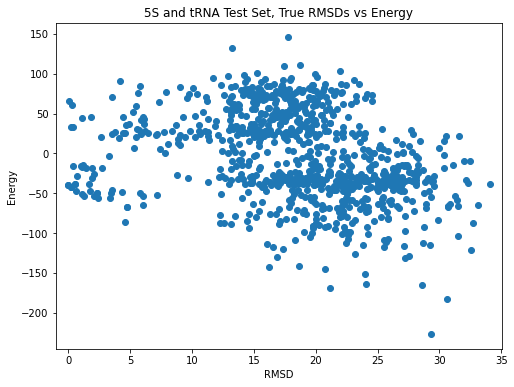

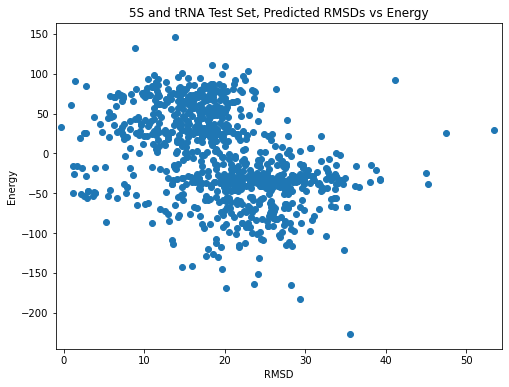

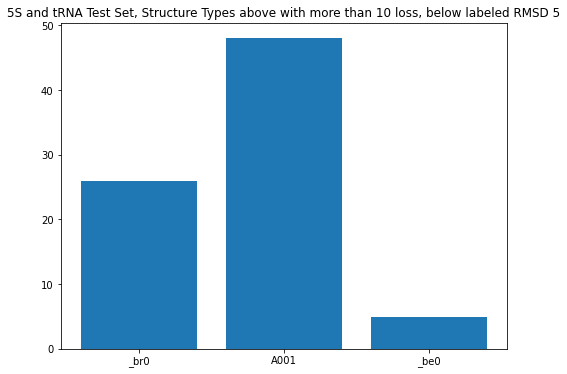

Prediction below 0: Label 0.0000, Pred -0.2323
Prediction below 0: Label 0.0000, Pred -0.8587
Prediction below 0: Label 0.0000, Pred -0.2323
Prediction below 0: Label 0.0000, Pred -0.2323
Prediction below 0: Label 0.0920, Pred -0.3592
Prediction below 0: Label 0.0920, Pred -0.3592
Prediction below 0: Label 0.0000, Pred -0.8587
Prediction below 0: Label 0.0000, Pred -0.0063
Prediction below 0: Label 0.3080, Pred -0.8041
Prediction below 0: Label 0.0000, Pred -0.8587
Prediction below 0: Label 0.0340, Pred -0.8114
Prediction below 0: Label 0.0000, Pred -0.0063
Prediction below 0: Label 0.0920, Pred -0.3592
Prediction below 0: Label 0.0000, Pred -0.0063
Training Set
Minimum Loss: Label = 0.0000, Prediction = -0.0063, Loss = 0.0000
Maximum Loss: Label = 24.1790, Prediction = 33.1895, Loss = 8.5105
Mean Test loss: 	 1.1357
Std. Dev. of Test loss:  1.2680
Min loss: 		 0.0000
First Quantile: 	 0.1391
Median: 		 0.6830
Third Quantile: 	 1.7541
Max Loss: 		 8.5105
LinregressResult(slope=0.910210

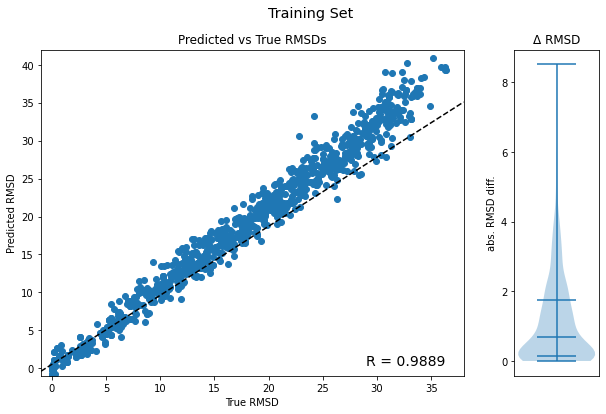

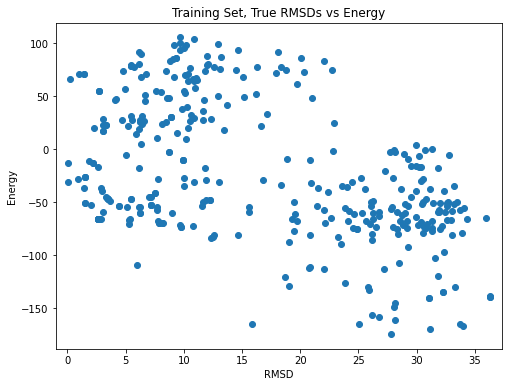

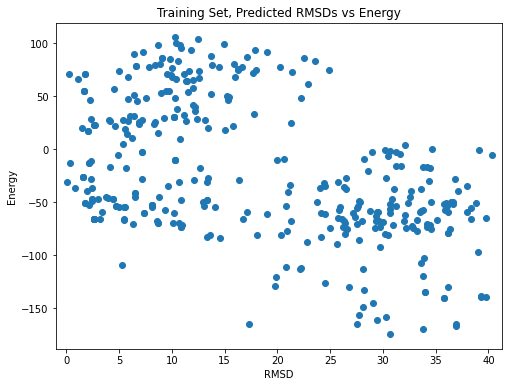

Validation Set
Minimum Loss: Label = 14.3250, Prediction = 14.3748, Loss = 0.0012
Maximum Loss: Label = 0.0000, Prediction = 94.6046, Loss = 94.1046
Mean Test loss: 	 15.7123
Std. Dev. of Test loss:  15.0759
Min loss: 		 0.0012
First Quantile: 	 4.1485
Median: 		 11.1720
Third Quantile: 	 23.7823
Max Loss: 		 94.1046
LinregressResult(slope=-0.20275116602086848, intercept=28.604979639327514, rvalue=-0.15905628752872022, pvalue=0.001496235642147013, stderr=0.06340158798890141, intercept_stderr=1.8562535218969813)


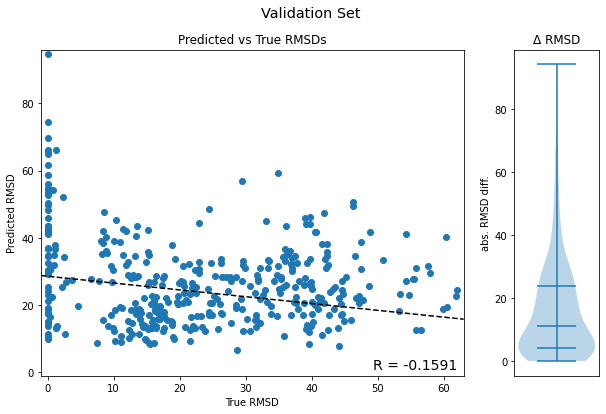

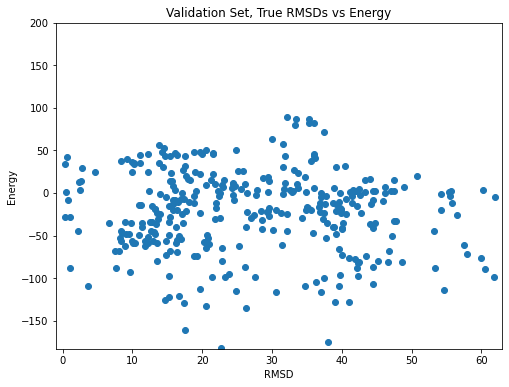

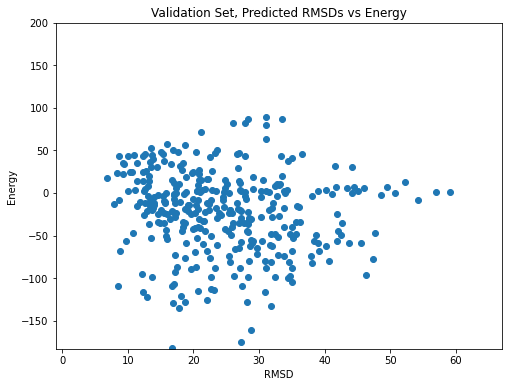

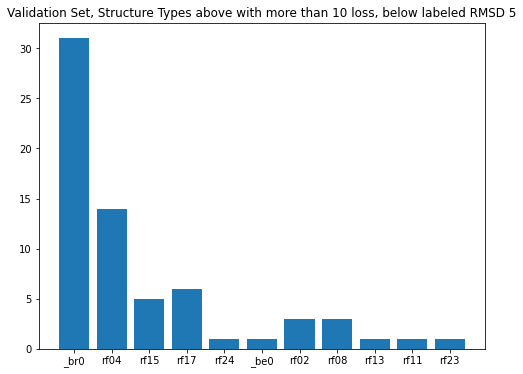

LinregressResult(slope=0.31916500699787137, intercept=13.956075612468064, rvalue=0.27798631718806044, pvalue=7.3082819811998435e-28, stderr=0.028581190639215836, intercept_stderr=0.664121452863125)


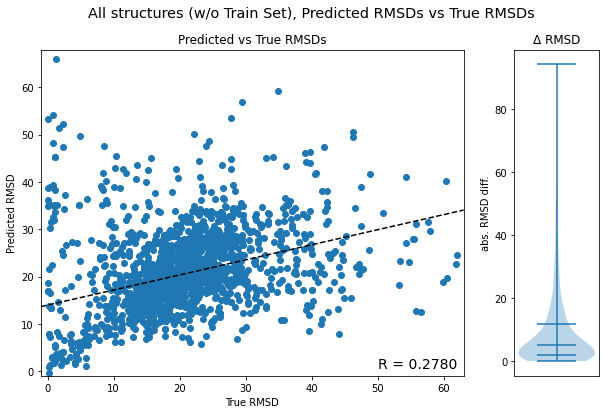

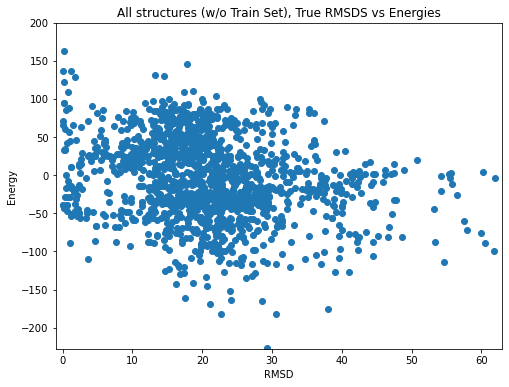

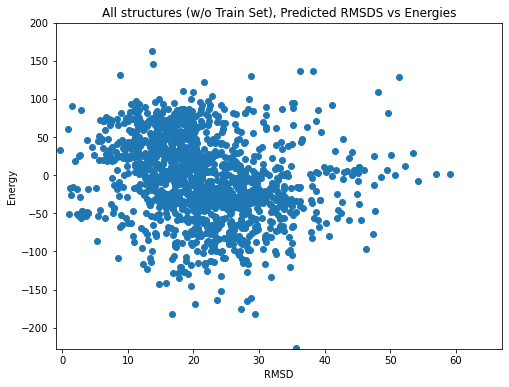

In [6]:
#Test
from run.utility import rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth", map_location=device)
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_list = "../data/test_energy.txt"
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_list = "../data/old_train_energy.txt"
    elif loader == train_loader:
        title = "Training Set"
        e_list = "../data/train_energy.txt"
    elif loader == val_loader:
        title = "Validation Set"
        e_list = "../data/val_energy.txt"
    en, trs, prs, tlosses = test(model, loader, title, device, e_list, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

In [ ]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(figsize=(8, 6)) #layout='constrained',
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots( figsize=(8, 6)) #layout='constrained',
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")